<a href="https://colab.research.google.com/github/Kishan459/NYC-Taxi-Trip-Time_prediction/blob/main/NYC_Taxi_Trip_Time_Prediction_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Taxi trip time Prediction : Predicting total ride duration of taxi trips in New York City</u></b>

## <b> Problem Description </b>

### Your task is to build a model that predicts the total ride duration of taxi trips in New York City. Your primary dataset is one released by the NYC Taxi and Limousine Commission, which includes pickup time, geo-coordinates, number of passengers, and several other variables.

## <b> Data Description </b>

### The dataset is based on the 2016 NYC Yellow Cab trip record data made available in Big Query on Google Cloud Platform. The data was originally published by the NYC Taxi and Limousine Commission (TLC). The data was sampled and cleaned for the purposes of this project. Based on individual trip attributes, you should predict the duration of each trip in the test set.

### <b>NYC Taxi Data.csv</b> - the training set (contains 1458644 trip records)


### Data fields
* #### id - a unique identifier for each trip
* #### vendor_id - a code indicating the provider associated with the trip record
* #### pickup_datetime - date and time when the meter was engaged
* #### dropoff_datetime - date and time when the meter was disengaged
* #### passenger_count - the number of passengers in the vehicle (driver entered value)
* #### pickup_longitude - the longitude where the meter was engaged
* #### pickup_latitude - the latitude where the meter was engaged
* #### dropoff_longitude - the longitude where the meter was disengaged
* #### dropoff_latitude - the latitude where the meter was disengaged
* #### store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip
* #### trip_duration - duration of the trip in seconds

#### importing libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV,RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler , MinMaxScaler
import warnings; warnings.simplefilter('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# import Dataset
df = pd.read_csv('/content/drive/MyDrive/Datasets/NYC Taxi Data (1).csv')

In [4]:
# checking the shape of data
df.shape

(1458644, 11)

In [5]:
# checking for null values
df.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

##### There are no nan/null record in dataset. so we don't have to impute any record.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


#### pickup_datetime,drpoff_datetime are object datatype we have to covert them into datetime format.

In [7]:
# converting timestamp to datatime format
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime'])

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1458644 non-null  object        
 1   vendor_id           1458644 non-null  int64         
 2   pickup_datetime     1458644 non-null  datetime64[ns]
 3   dropoff_datetime    1458644 non-null  datetime64[ns]
 4   passenger_count     1458644 non-null  int64         
 5   pickup_longitude    1458644 non-null  float64       
 6   pickup_latitude     1458644 non-null  float64       
 7   dropoff_longitude   1458644 non-null  float64       
 8   dropoff_latitude    1458644 non-null  float64       
 9   store_and_fwd_flag  1458644 non-null  object        
 10  trip_duration       1458644 non-null  int64         
dtypes: datetime64[ns](2), float64(4), int64(3), object(2)
memory usage: 122.4+ MB


In [9]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [10]:
# extracting hour,month,weekday,weekday_number from datatime feature
df['pickup_hour'] = df['pickup_datetime'].dt.hour
df['pickup_month'] = df['pickup_datetime'].dt.month
df['weekday_num'] = df['pickup_datetime'].dt.dayofweek
df['weekday_day'] = df['pickup_datetime'].dt.day_name()

In [11]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_hour,pickup_month,weekday_num,weekday_day
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,17,3,0,Monday
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,0,6,6,Sunday
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,11,1,1,Tuesday
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,19,4,2,Wednesday
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,13,3,5,Saturday


In [12]:
!pip install haversine

In [13]:
# import haversine to calulate distance from pickup and drpoff latitude and longitude
import haversine as hs

In [14]:
# function for calculating distance
def calculate_distance(df):
  pickup = (df['pickup_latitude'],df['pickup_longitude'])
  drop = (df['dropoff_latitude'],df['dropoff_longitude'])
  return hs.haversine(pickup,drop)

In [15]:
# calculating distance 
df['distance'] = df.apply(lambda x : calculate_distance(x),axis=1)

In [16]:
#Calculate Speed in km/h for further insights
df['speed'] = round((df.distance/(df.trip_duration/3600)),2)

In [17]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_hour,pickup_month,weekday_num,weekday_day,distance,speed
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,17,3,0,Monday,1.498523,11.86
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,0,6,6,Sunday,1.805510,9.80
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,11,1,1,Tuesday,6.385107,10.82
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,19,4,2,Wednesday,1.485500,12.47
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,13,3,5,Saturday,1.188590,9.84


#Univeriate Analysis

##Vendor ID

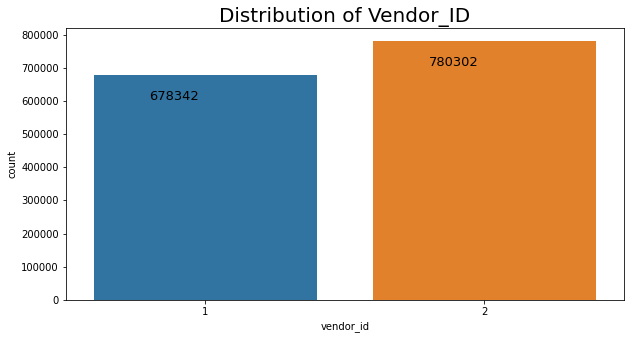

In [18]:
# finding which vender have large market share
plt.figure(figsize=(10,5))
ax = sns.countplot(df['vendor_id'])
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), va='top', color='black', size=13)
plt.title('Distribution of Vendor_ID',fontsize=20)
plt.show()

#### vender with id 2 has large market share than vender with id 1

##Store_and_fwd_flag

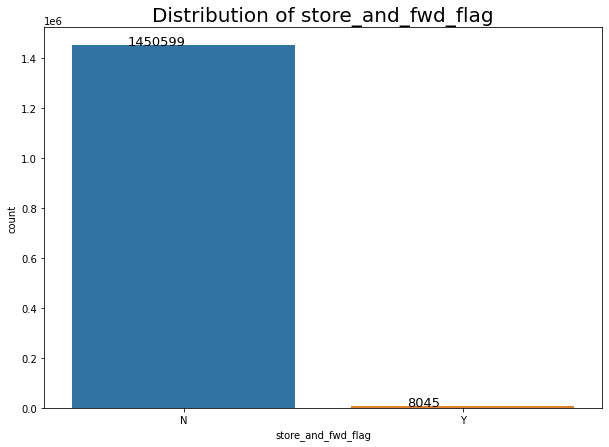

In [19]:
# finding frequency of trip according to trip record was held in vehicle or not 
plt.figure(figsize=(10,7))
ax = sns.countplot(df['store_and_fwd_flag'])
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), color='black', size=13)
plt.title('Distribution of store_and_fwd_flag',fontsize=20)
plt.show()

In [20]:
round(df['store_and_fwd_flag'].value_counts(normalize=True),2)

N    0.99
Y    0.01
Name: store_and_fwd_flag, dtype: float64

#### Above result shows that only about 1% of the trip details were stored in the vehicle first before sending it to the server.

##PickUp Hour

Text(0.5, 1.0, 'Distribution of pickup_hour')

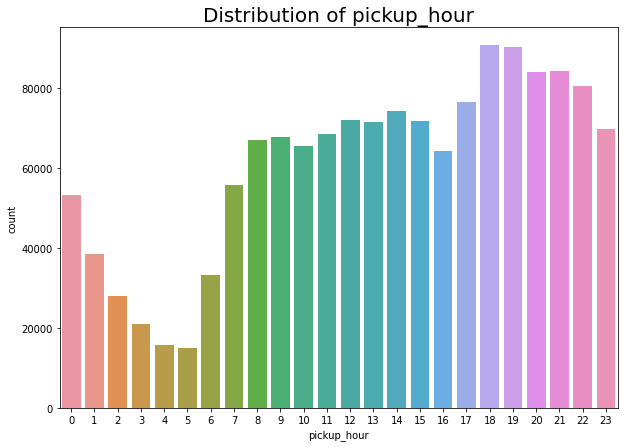

In [21]:
# visualization of frequency of trip according to pick_hour
plt.figure(figsize=(10,7))
sns.countplot(df['pickup_hour'])
plt.title('Distribution of pickup_hour',fontsize=20)

#### pickup hour is on its peak at 18 to 22 hour (evening) ,followed by 12 to 15 (Afternoon).
#### and pickup hour is on its lowest at 4 to 5 hour (early morning).

In [22]:
# frequency of trip according to pick_hour
df['pickup_hour'].value_counts()

18    90600
19    90308
21    84185
20    84072
22    80492
17    76483
14    74292
12    71873
15    71811
13    71473
23    69785
11    68476
9     67663
8     67053
10    65437
16    64313
7     55600
0     53248
1     38571
6     33248
2     27972
3     20895
4     15792
5     15002
Name: pickup_hour, dtype: int64

##PickUP Month

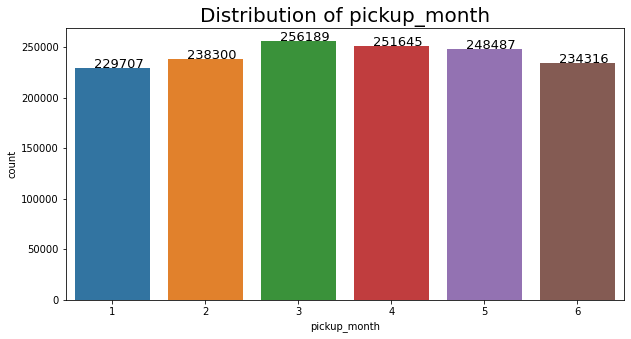

In [23]:
# visualization of frequency of trip according to month
plt.figure(figsize=(10,5))
ax = sns.countplot(df['pickup_month'])
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), color='black', size=13)
plt.title('Distribution of pickup_month',fontsize=20)
plt.show()

####dropoff_datetime has a extra month compared to pickup_datetime column with only 127 observatons when dropoff_datetime month is 7 , this is becuase people have taken ride at late night of last date of 6th month.

#### Trip accross the month is nearly balanced

##WeekDays

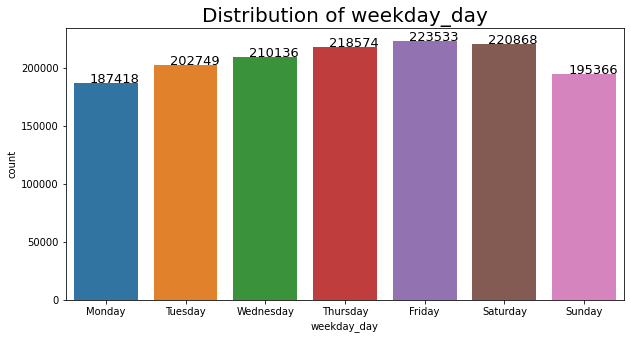

In [24]:
# visualization of trip frequancy according to weekday
plt.figure(figsize=(10,5))
ax = sns.countplot(df['weekday_day'],order=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday","Sunday"])
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), color='black', size=13)
plt.title('Distribution of weekday_day',fontsize=20)
plt.show()

#####Here we can see an increasing trend of taxi pickups starting from Monday till Friday. The trend starts declining from saturday till monday which is normal where some office going people likes to stay at home for rest on the weekends.

In [25]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_hour,pickup_month,weekday_num,weekday_day,distance,speed
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,17,3,0,Monday,1.498523,11.86
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,0,6,6,Sunday,1.805510,9.80
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,11,1,1,Tuesday,6.385107,10.82
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,19,4,2,Wednesday,1.485500,12.47
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,13,3,5,Saturday,1.188590,9.84


##Passanger Count

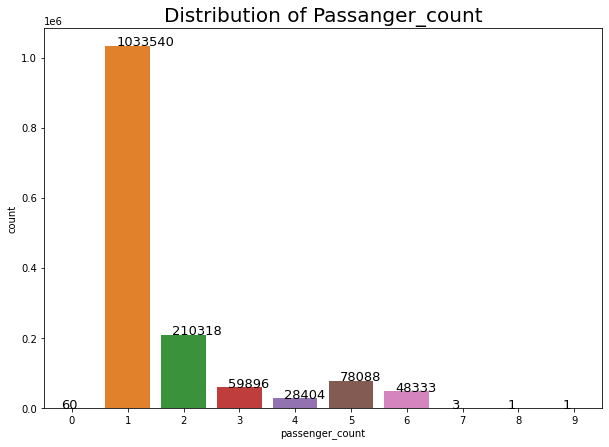

In [26]:
# finding frequency of trip according to number of passanger.
plt.figure(figsize=(10,7))
ax = sns.countplot(df['passenger_count'])
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), color='black', size=13)
plt.title('Distribution of Passanger_count',fontsize=20)
plt.show()

#### most of the trip is taken by the single passanger and there are very fewer no. of trip is taken by more then 6 passengers and they might be outliers because fitting more then is not possible. 6 people is possible which contain 1 child and driver. 0 is outlier too.

In [27]:
# frequency of trips count according to passanger count
df['passenger_count'].value_counts()

1    1033540
2     210318
5      78088
3      59896
6      48333
4      28404
0         60
7          3
9          1
8          1
Name: passenger_count, dtype: int64

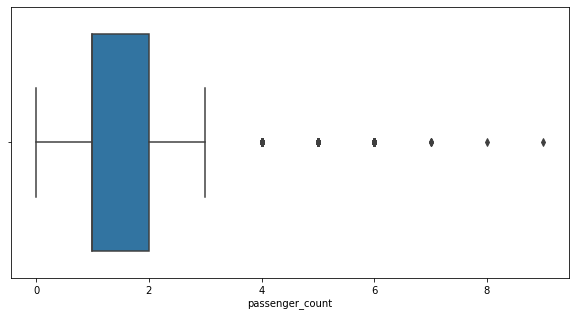

In [28]:
# boxplot of passanger count
plt.figure(figsize=(10,5))
sns.boxplot(df['passenger_count'])

#### there are some trips with 0 passanger count.
#### few trips consist of 7,8,9 passanger , they are outliers
#### most of the trips consist of 1 or 2 passangers.

In [29]:
# summary statistics of passanger count
df.passenger_count.describe().astype('int')

count    1458644
mean           1
std            1
min            0
25%            1
50%            1
75%            2
max            9
Name: passenger_count, dtype: int64

#### Mean,Median and mode are same.
#### passanger count has standard deviation of 1.
#### Minimum passanger count is 0.Since trips not possible without customers we will remove this.
#### Max passanger count is 9 which is clearly outlier we will remove it too.

In [30]:
# removing the outliers from passanger count
df = df[df.passenger_count > 0]
df = df[df.passenger_count <= 6]

#### Acoording to www1.nyc.gov The maximum amount of passengers allowed in a yellow taxicab by law is four (4) in a four (4) passenger taxicab or five (5) passengers in a five (5) passenger taxicab, except that an additional passenger must be accepted if such passenger is under the age of seven (7) and is held on the lap of an adult passenger seated in the rear.
#### So, in total we can assume that maximum 6 passenger can board the new york taxi i.e. 5 adult + 1 minor
#### Since trips not possible without customers thats why I removed trips with 0 passangers and more than 6 passanger can't sit in a taxi thats why I removed more trips with more than 6 passangers(they are outliers)

In [31]:
# frequency of trips count according to passanger count after removing outliers
df.passenger_count.value_counts()

1    1033540
2     210318
5      78088
3      59896
6      48333
4      28404
Name: passenger_count, dtype: int64

In [32]:
df.shape

(1458579, 17)

#### After removing Outliers from passanger count we are left with 1458579 observations.

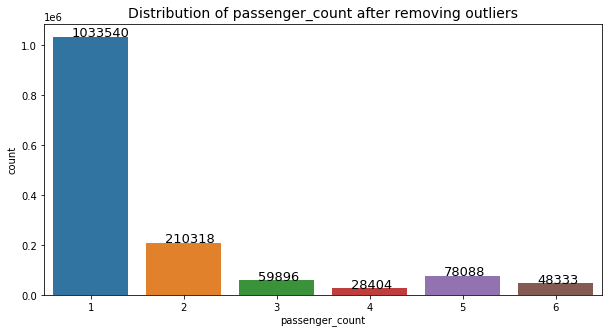

In [33]:
# visualization of passanger count after removing outliers 
plt.figure(figsize=(10,5))
ax = sns.countplot(df.passenger_count)
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), color='black', size=13)
plt.title('Distribution of passenger_count after removing outliers',fontsize=14)
plt.show()

##Distance

In [34]:
# summary statistics of Distance
round(df['distance'].describe(),2)

count    1458579.00
mean           3.44
std            4.30
min            0.00
25%            1.23
50%            2.09
75%            3.88
max         1240.91
Name: distance, dtype: float64

#### Distances are in Kilometers
#### some trips with 0 km
#### some trips are over 100km
#### Mean distane is approx 3.5 km and standard deviation is 4.3 km which means most of the trips are in range of 1 to 10 km

In [35]:
df['distance'].unique().shape

(1452234,)

In [36]:
df[df['distance']==0].shape

(5887, 17)

#### There are 5887 trips whith 0 distance.

#####Customer might have changed thier mind and cancelled the journey just after accepting it.
#####Driver might have cancelled the trip just after accepting it due to some reason. So the trip couldn't start.


In [37]:
# finding no. of observations with more than 100km
df[df['distance']>=100].shape

(19, 17)

#### There are only 19 trips more than 100 km 

In [38]:
# finding no. of trips with more than 10km
df[df['distance']>10].shape

(89133, 17)

#### There are 89133 trips with more than 10 km 

In [39]:
# finding no. of trips with more than 0 km and less than and equal to 10 km
df[(df['distance']<=10) & (df['distance']>0)].shape

(1363559, 17)

#### There are 1363559 trips in range of 1 to 10 km 

In [40]:
# finding no. of trips with more than 0 km and less than and equal to 30 km
df[(df['distance']<=30) & (df['distance']>0)].shape

(1452119, 17)

#### we have to predict the trip duration inside New York Ciy.
#### The radius of New York City is 30 km approx. So we are going to treat Trips with Distance more than 30 km as outliers.

In [41]:
# removed outliers from distance
df = df[(df['distance']>0) & (df['distance']<=30)]

In [42]:
df.shape

(1452119, 17)

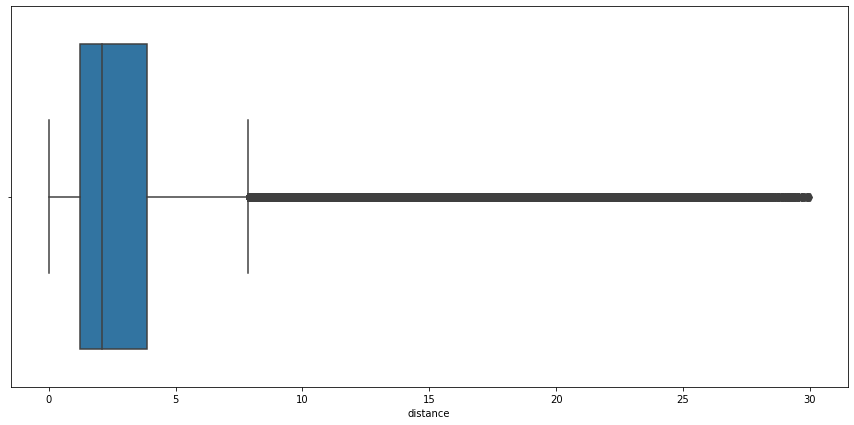

In [43]:
# ploting distance's boxplot
plt.figure(figsize=(15,7))
sns.boxplot(df['distance'])

In [44]:
# summary statistic of speed
round(df.speed.describe(),2)

count    1452119.00
mean          14.45
std           11.44
min            0.00
25%            9.17
50%           12.82
75%           17.87
max         9274.85
Name: speed, dtype: float64

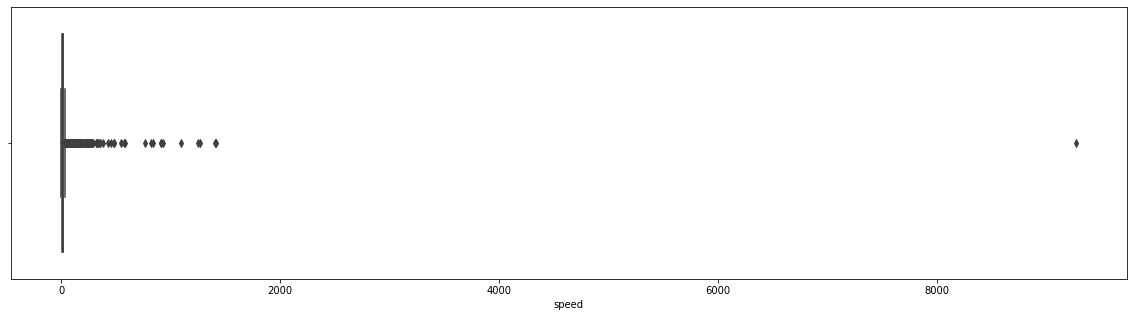

In [45]:
# ploting speed's boxplot
plt.figure(figsize = (20,5))
sns.boxplot(df['speed'])

#### we can see that maximum speed of trip is 9274.85 km/h and minimum is 0 km/h.
#### According to https://www.newyorksafetycouncil.com/ ,Average speed limit in urban area is i.e. 40 km/h.
#### And 65 mph on controlled state highways i.e. approx 104 km/h.
#### so we are going to remove all those trips with more than 104 m/h.

In [46]:
# removing outliers
df = df[df['speed']<=104]

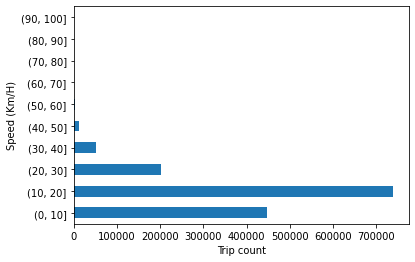

In [47]:
# visualization of frequency of trips according to speed ranges
df.speed.groupby(pd.cut(df.speed, np.arange(0,104,10))).count().plot(kind = 'barh')
plt.xlabel('Trip count')
plt.ylabel('Speed (Km/H)')
plt.show()

#### We can see that most of the trips are in range of 10 to 20 km.
#### and least no of trips are done in range of (30 to 40) km and (40 to 50) km.


##Trip Duration

In [48]:
# summary statistics of Trip Duration
df['trip_duration'].describe().astype('int')

count    1451978
mean         960
std         5245
min            1
25%          398
50%          663
75%         1076
max      3526282
Name: trip_duration, dtype: int64

#### In summary statistics of trip Duration we can see that Mean trip Duration is 960 seconds. Standard deviation is 5245 seconds. upto 75% trip's duration is less than 1076 seconds.Minumun duration is 1 second and Max duration is 3526282 seconds (40 days approx) which means there are outliers. 

#### we will remove outliers after comparing distance with trip duration at the time of doing Bivariate Analysis.

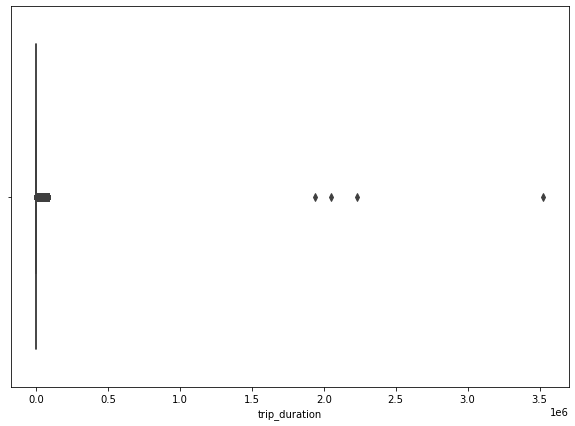

In [49]:
# boxplot of trip duration
plt.figure(figsize=(10,7))
sns.boxplot(df['trip_duration'])

In [50]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_hour,pickup_month,weekday_num,weekday_day,distance,speed
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,17,3,0,Monday,1.498523,11.86
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,0,6,6,Sunday,1.805510,9.80
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,11,1,1,Tuesday,6.385107,10.82
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,19,4,2,Wednesday,1.485500,12.47
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,13,3,5,Saturday,1.188590,9.84


#Bivariate Analysis

##Trip Duration Vs Vendor

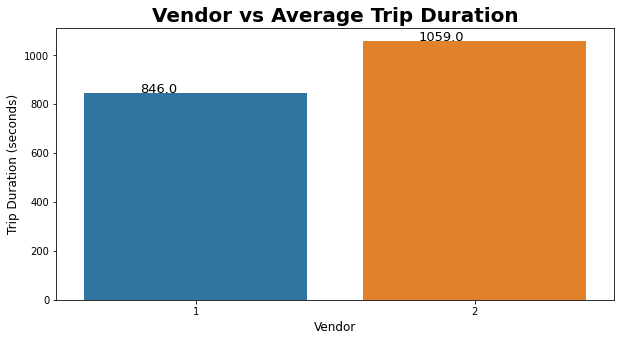

In [51]:
# visualization of vendor id and Average trip duration
plt.figure(figsize=(10,5))
vendor_id_trip_d = round(df.groupby('vendor_id')['trip_duration'].mean(),0)
ax = sns.barplot(vendor_id_trip_d.index,vendor_id_trip_d.values)
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), color='black', size=13)
plt.ylabel('Trip Duration (seconds)',fontsize=12)
plt.xlabel('Vendor',fontsize=12)
plt.title('Vendor vs Average Trip Duration',fontsize=20,weight='bold')
plt.show()

#### Average trip diration of Vendor 2 is higher than Vendor 1 by 200 seconds approx

## Trip Duration Vs Passanger Count

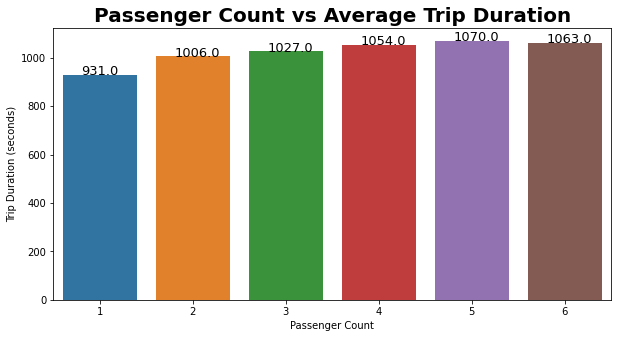

In [52]:
# visualization of Passanger Count and Average trip duration
passanger_Count_vs_trip_d = round(df.groupby('passenger_count')['trip_duration'].mean(),0)
plt.figure(figsize=(10,5))
ax = sns.barplot(passanger_Count_vs_trip_d.index,passanger_Count_vs_trip_d.values)
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), color='black', size=13)
plt.ylabel('Trip Duration (seconds)')
plt.xlabel('Passenger Count')
plt.title('Passenger Count vs Average Trip Duration',fontsize=20,weight='bold')
plt.show()

#### Trip duration for all the passanger counts are aprrox similar. except passanger count 1( average trip duratuion of passanger count 1 is lower than others).

##Trip Duration Vs PickUp_Hour

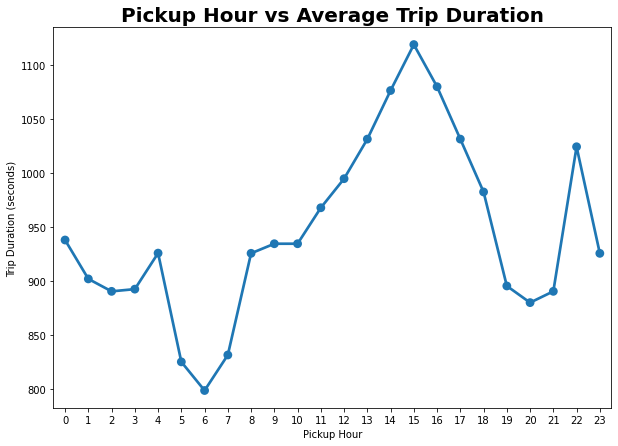

In [53]:
# visualization of PickUp Hour and Average trip duration
td_ph = df.groupby('pickup_hour')['trip_duration'].mean()
plt.figure(figsize=(10,7))
sns.pointplot(td_ph.index,td_ph.values)
plt.ylabel('Trip Duration (seconds)')
plt.xlabel('Pickup Hour')
plt.title('Pickup Hour vs Average Trip Duration',fontsize=20,weight='bold')
plt.show()

#### Average trip duration is lower at 6am in the morning due to minimal traffic on the road. and higher at 15 hour(3pm) because streets are bust at this time.

## Trip Duration vs PickUp Month

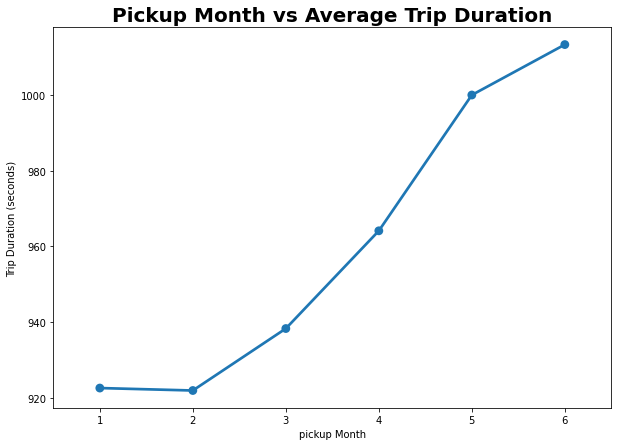

In [54]:
# visualization of PickUp Month and Average trip duration
td_pm = df.groupby('pickup_month')['trip_duration'].mean()
plt.figure(figsize=(10,7))
sns.pointplot(td_pm.index,td_pm.values)
plt.ylabel('Trip Duration (seconds)')
plt.xlabel('pickup Month')
plt.title('Pickup Month vs Average Trip Duration',fontsize=20,weight='bold')
plt.show()

#### Average Trip duration is increasing along with each subsequent month.
#### we can see that at the time of winter jan and feb average trip duration is less may be due to less traffic in winters but as summer approches the average trip duration is started increasing.

##Trip Duration vs WeekDays

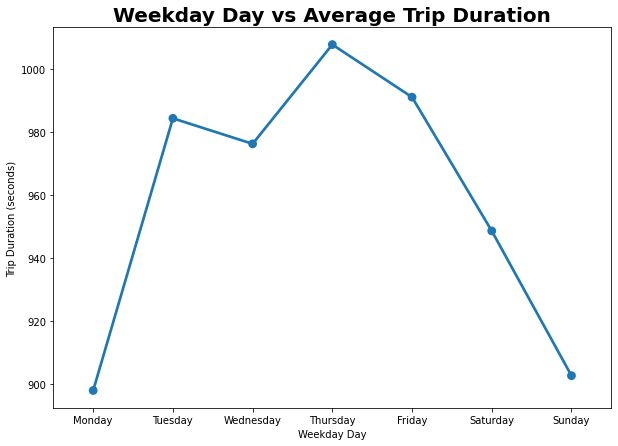

In [55]:
# visualization of weekdays and Average trip duration
td_pwd = df.groupby('weekday_day')['trip_duration'].mean()
plt.figure(figsize=(10,7))
sns.pointplot(td_pwd.index,td_pwd.values,order=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday","Sunday"])
plt.ylabel('Trip Duration (seconds)')
plt.xlabel('Weekday Day')
plt.title('Weekday Day vs Average Trip Duration',fontsize=20,weight='bold')
plt.show()

#### we can see that Average trip duration is alomst same and lowest on monday and sunday.
#### Average trip duration is highest on thrusday.

In [56]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_hour,pickup_month,weekday_num,weekday_day,distance,speed
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,17,3,0,Monday,1.498523,11.86
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,0,6,6,Sunday,1.805510,9.80
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,11,1,1,Tuesday,6.385107,10.82
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,19,4,2,Wednesday,1.485500,12.47
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,13,3,5,Saturday,1.188590,9.84


## Distance vs Strore and Fwd Flag

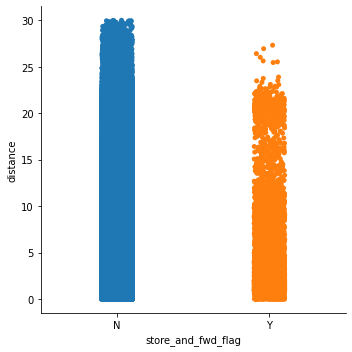

In [57]:
# visulatization of distance vs store_and_fwd_flag using cat plot
sns.catplot(y='distance',x='store_and_fwd_flag',data=df,kind='strip')

#### we can se that most of the trip not held in the vehicle memory.
####  and longer distance trip'S flag was not stored.

## Distance vs Vendor 

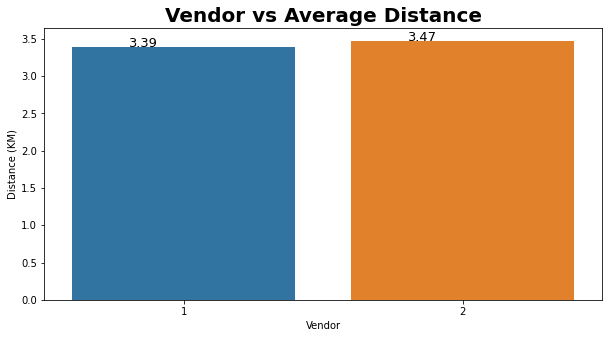

In [58]:
# visualization Average distance traveled by per vendor
plt.figure(figsize=(10,5))
vi_vs_d = round(df.groupby('vendor_id')['distance'].mean(),2)
ax = sns.barplot(vi_vs_d.index,vi_vs_d.values)
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), color='black', size=13)
plt.ylabel('Distance (KM)')
plt.xlabel('Vendor')
plt.title('Vendor vs Average Distance',fontsize=20,weight='bold')
plt.show()

#### Average distance travel by both vendors is kind of similar.

## Distance Vs Pickup Hour

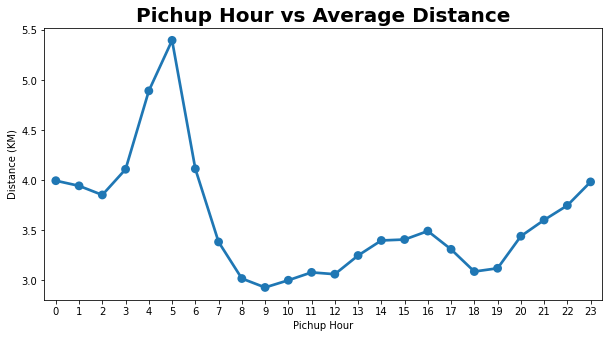

In [59]:
# visualization of Average distance by Pickup Hour
plt.figure(figsize=(10,5))
ph_vs_d =  df.groupby('pickup_hour')['distance'].mean()
sns.pointplot(ph_vs_d.index,ph_vs_d.values)
plt.ylabel('Distance (KM)')
plt.xlabel('Pichup Hour')
plt.title('Pichup Hour vs Average Distance',fontsize=20,weight='bold')
plt.show()

####Average Trip distance is heighest in the early morning between 4 to 6 am.
#### and kinda similar from morning to evening varing around 3 to 3.5 km.
#### then it started increasing from evening throughout late night till 5 am in the morning.

##Distance Vs Pickup Month

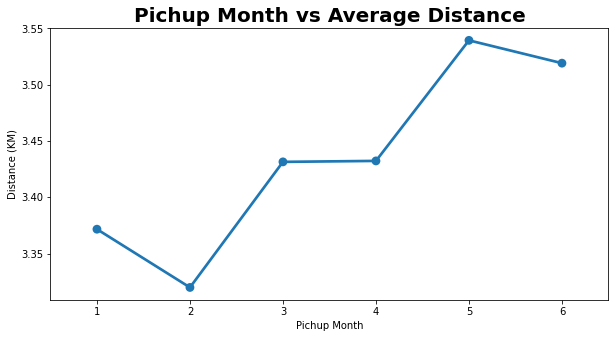

In [60]:
# visualization of Average distance by Pickup Month
plt.figure(figsize=(10,5))
pm_vs_d = df.groupby('pickup_month')['distance'].mean()
sns.pointplot(pm_vs_d.index,pm_vs_d.values)
plt.ylabel('Distance (KM)')
plt.xlabel('Pichup Month')
plt.title('Pichup Month vs Average Distance',fontsize=20,weight='bold')
plt.show()

#### Average Trip distance is lowest in Feb and heighest in may.
#### Average Trip distance is varing around 3 to 3.5 km acorss the month except 2nd month(feb).

## Distance vs weekdays

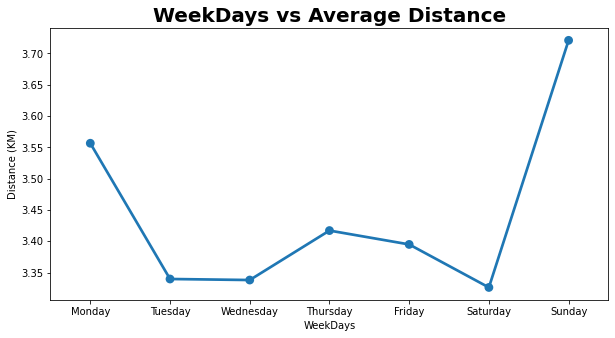

In [61]:
# visualization of Average distance by weekdays
plt.figure(figsize=(10,5))
wd_vs_d = df.groupby('weekday_day')['distance'].mean()
sns.pointplot(wd_vs_d.index,wd_vs_d.values,order=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday","Sunday"])
plt.ylabel('Distance (KM)')
plt.xlabel('WeekDays')
plt.title('WeekDays vs Average Distance',fontsize=20,weight='bold')
plt.show()

#### Average Trip Distance in between Tuesday to Saturday is in range of 3 to 3.4 km.
#### Maximum Average trip distance is on sunday followed by monday. and mimimun on Saturday.

## Distance vs Trip Duration

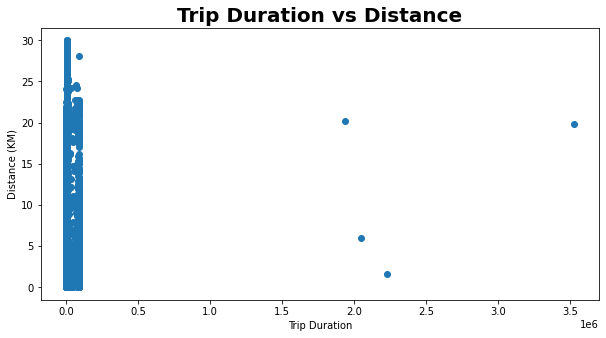

In [62]:
# visualization of distance and trip duration
plt.figure(figsize=(10,5))
plt.scatter(df.trip_duration, df.distance)
plt.ylabel('Distance (KM)')
plt.xlabel('Trip Duration')
plt.title('Trip Duration vs Distance',fontsize=20,weight='bold')
plt.show()

#### There are some trips which less than 25km but duration is more than 20000 seconds.

#### lets take trip duration less 2000 seconds and then analyze the graph.

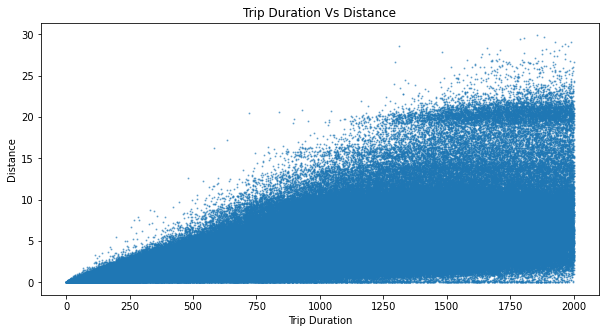

In [63]:
# visualization of distance and trip duration less than 2000 seconds
plt.figure(figsize=(10,5))
dis_ = df[df['trip_duration']<2000][['distance','trip_duration']]
plt.scatter(dis_.trip_duration,dis_.distance , s=1, alpha=0.5)
plt.ylabel('Distance')
plt.xlabel('Trip Duration')
plt.title('Trip Duration Vs Distance')
plt.show()

#### we can see that there is non linera relationship between trip duration and distance may be because of traffics and all.
#### we are going to remove all those trips with duration less then 60 seconds. Bcause there are 7053 trips with less than 60 seonds may be because people will cancled their booking within 60 seconds of booking.

In [64]:
# removing trips with duration less than 60 seconds.
df = df[df['trip_duration']>60]

#### And now we are going to remove those trips which traveled less than equal to 1 km and has taken more than half hour to bring in more consistency to our results.

In [65]:
# removing trips whise distance is less than 1 km and trip duration is more than 1700 seconds(30 minutes)
df = df[~((df['distance'] <= 1) & (df['trip_duration'] >= 1700))]

## Passanger vs Vendor

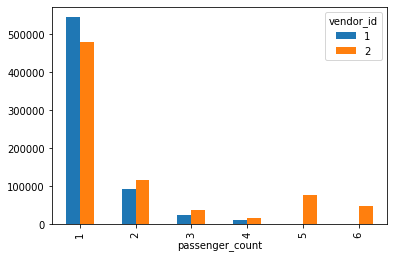

In [66]:
# visualization of trip done by vendors according to passanger count
df.groupby('passenger_count').vendor_id.value_counts().reset_index(name='count').pivot("passenger_count","vendor_id","count").plot(kind='bar')
plt.show()

#### from the above visualization we can understand that vender 2 has more market share than vendor 1.
#### And vender 2 are carrying more number of people which means vendor 2 has more big cars or may be vendor 2 allow more passanger to sit.
#### vendor 1 has large market share in term of single passanger may be because vendor 1 has more minicars than big cars.

In [67]:
# removing trips with duration more than 20000 seconds.
df = df[df['trip_duration']<20000]

In [68]:
df.shape

(1441878, 17)

## Speed vs Pickup  Hour

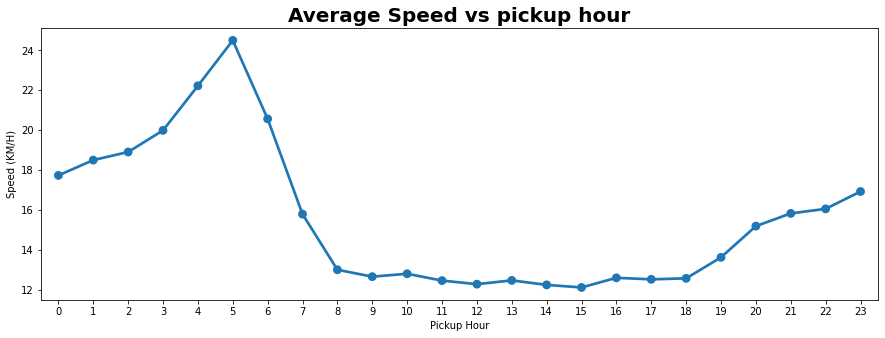

In [69]:
# visualization of Average speed by pickup hour
plt.figure(figsize=(15,5))
speed_vs_ph =  df.groupby('pickup_hour')['speed'].mean()
sns.pointplot(speed_vs_ph.index,speed_vs_ph.values)
plt.ylabel('Speed (KM/H)')
plt.xlabel('Pickup Hour')
plt.title('Average Speed vs pickup hour',fontsize=20,weight='bold')
plt.show()

#### As we can see that average speed is heighest in the early morning between 4 to 6 am which is in range of 20 to 24 km/h, when traffic is less. and started decreasing when office hours approches.
#### Average taxi speed is more or less same during the office hours i.e. from 8 AM till 6PM in the evening. which is in range of 12 to 13 km/h.
#### And then strated increasing from 6 pm to 5 am in the morning.

## Speed Vs Weekdays

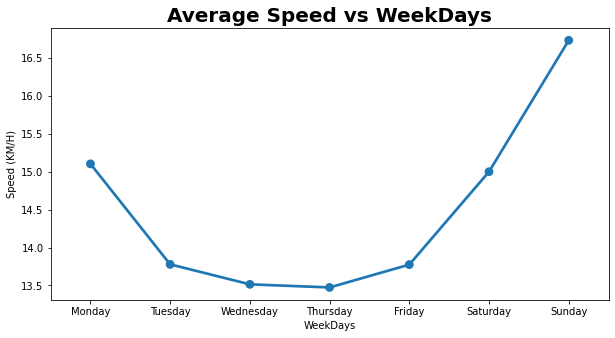

In [70]:
# visualization of Average speed by weekdays
plt.figure(figsize=(10,5))
speed_vs_wd =  df.groupby('weekday_day')['speed'].mean()
sns.pointplot(speed_vs_wd.index,speed_vs_wd.values,order=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday","Sunday"])
plt.ylabel('Speed (KM/H)')
plt.xlabel('WeekDays')
plt.title('Average Speed vs WeekDays',fontsize=20,weight='bold')
plt.show()

#### Average speed is heighest during the weeknds in compare to weekdays which is obvious because of office goers and all.

In [71]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_hour,pickup_month,weekday_num,weekday_day,distance,speed
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,17,3,0,Monday,1.498523,11.86
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,0,6,6,Sunday,1.805510,9.80
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,11,1,1,Tuesday,6.385107,10.82
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,19,4,2,Wednesday,1.485500,12.47
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,13,3,5,Saturday,1.188590,9.84


In [72]:
df.shape

(1441878, 17)

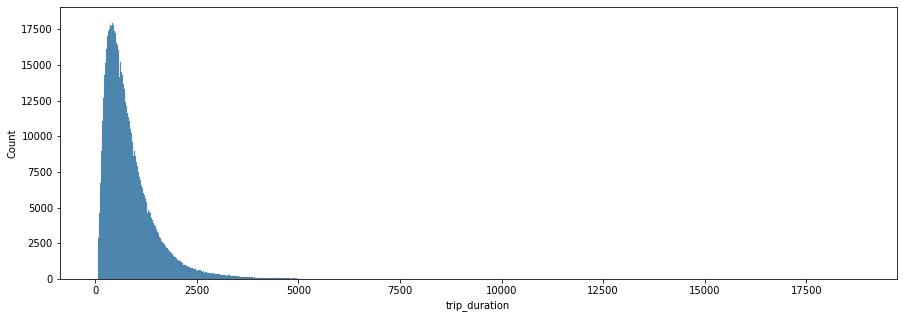

In [73]:
# checking distribution of trip duration
plt.figure(figsize=(15,5))
sns.histplot(df['trip_duration'])

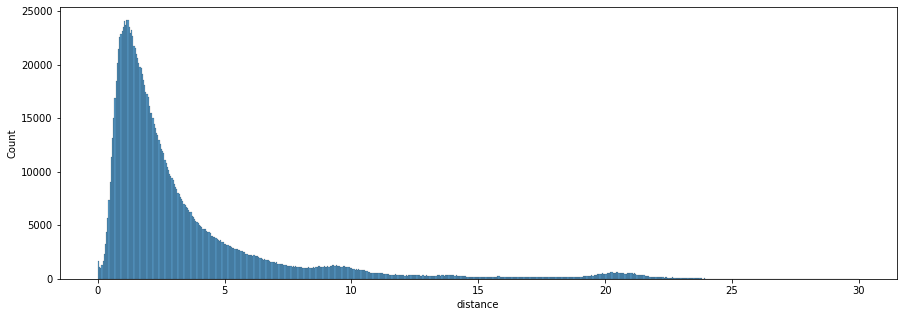

In [74]:
# checking distribution of trip distace
plt.figure(figsize=(15,5))
sns.histplot(df['distance'])

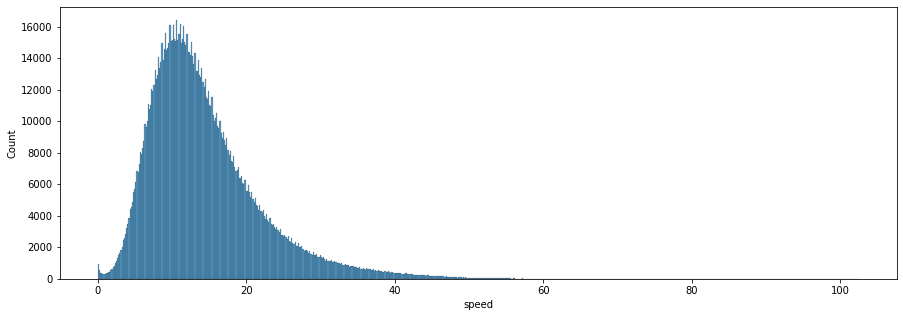

In [75]:
# checking distribution of trip speed
plt.figure(figsize=(15,5))
sns.histplot(df['speed'])

#### As we can see speed,distance and trip duration is right skewed we will use log transfomation.

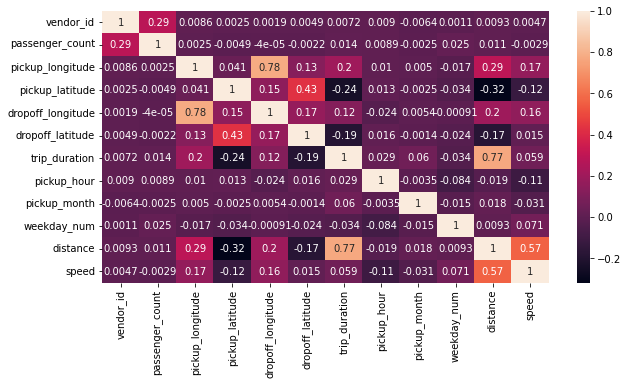

In [76]:
# correlation heatmap of data
plt.figure(figsize=(10,5))
sns.heatmap(df.corr(), annot=True)

In [77]:
# extractintg all the relevent features
features = ['vendor_id','passenger_count','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','store_and_fwd_flag','pickup_hour','pickup_month','weekday_day','distance','speed']

In [78]:
# diving dada according independent and dependent variable
X = df[features]
y = np.log(df['trip_duration'])

In [79]:
X.head()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,pickup_hour,pickup_month,weekday_day,distance,speed
0,2,1,-73.982155,40.767937,-73.964630,40.765602,N,17,3,Monday,1.498523,11.86
1,1,1,-73.980415,40.738564,-73.999481,40.731152,N,0,6,Sunday,1.805510,9.80
2,2,1,-73.979027,40.763939,-74.005333,40.710087,N,11,1,Tuesday,6.385107,10.82
3,2,1,-74.010040,40.719971,-74.012268,40.706718,N,19,4,Wednesday,1.485500,12.47
4,2,1,-73.973053,40.793209,-73.972923,40.782520,N,13,3,Saturday,1.188590,9.84


In [80]:
y

0          6.120297
1          6.496775
2          7.661056
3          6.061457
4          6.075346
             ...   
1458639    6.656727
1458640    6.484635
1458641    6.638568
1458642    5.921578
1458643    5.288267
Name: trip_duration, Length: 1441878, dtype: float64

In [81]:
# spliting the data
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=2)

In [82]:
# checking the shape of the splits
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((1153502, 12), (288376, 12), (1153502,), (288376,))

In [83]:
X_train.head()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,pickup_hour,pickup_month,weekday_day,distance,speed
901848,2,6,-73.986069,40.761257,-74.180962,40.695068,N,15,5,Thursday,17.996441,20.04
1435460,1,1,-73.984138,40.754990,-73.979439,40.761436,N,12,1,Wednesday,0.818886,12.87
767575,2,1,-73.982384,40.777012,-73.996353,40.738892,N,18,1,Tuesday,4.399059,9.48
977157,2,1,-73.974792,40.742020,-74.013390,40.641449,N,12,5,Monday,11.646816,18.77
795119,2,5,-73.978790,40.750000,-73.988060,40.751179,N,18,5,Saturday,0.791775,16.29


In [84]:
X.shape

(1441878, 12)

In [86]:
# preprosessing of data by using column transformer
step1 = ColumnTransformer(transformers=[
                          ('log',FunctionTransformer(np.log1p),['speed','distance']),
                          ('ohe',OneHotEncoder(sparse=False,drop='first'),['store_and_fwd_flag','weekday_day'])
                          
                        
                          

],remainder='passthrough')

# Linear Regression

In [87]:
# importing library to visualise pipeline
from sklearn import set_config
set_config(display='diagram')

In [88]:
# using pipeline to apply data preprosessing and linar regression together.
pipe = Pipeline(steps=[
                       ('step1',step1),
                       ('model',LinearRegression())

                       ])

In [89]:
#training the model
pipe.fit(X_train,y_train)

Pipeline(steps=[('step1',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('log',
                                                  FunctionTransformer(func=<ufunc 'log1p'>),
                                                  ['speed', 'distance']),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first',
                                                                sparse=False),
                                                  ['store_and_fwd_flag',
                                                   'weekday_day'])])),
                ('model', LinearRegression())])

In [90]:
# predicting y with respect to x_test.
y_pred = pipe.predict(X_test)

In [91]:
# predicting y with respect to x_train.
y_train_pred = pipe.predict(X_train)


In [92]:
# using evaluation metrics to evaluate our model.
lr_train_mse  = mean_squared_error(y_train, y_train_pred)
print("Train MSE :" , lr_train_mse)

lr_train_rmse = np.sqrt(lr_train_mse)

print("Train RMSE :" ,lr_train_rmse)

lr_train_r2 = r2_score(y_train, y_train_pred)
print("Train R2 :" ,lr_train_r2) 

lr_train_adjusted_r = 1-(1-r2_score(y_train, y_train_pred))*((X_train.shape[0]-1)/(X_train.shape[0]-X_train.shape[1]-1))
print("Train Adjusted R2 : ",lr_train_adjusted_r)

Train MSE : 0.021484972380573418
Train RMSE : 0.14657753027177603
Train R2 : 0.9594753778784757
Train Adjusted R2 :  0.9594749562919105


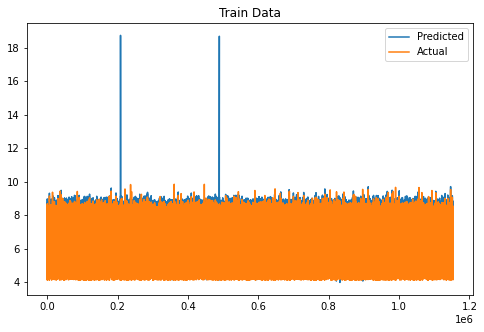

In [93]:
# visualization of actual and predicted.
plt.figure(figsize=(8,5))
plt.title('Train Data')
plt.plot(y_train_pred)
plt.plot(np.array(y_train))
plt.legend(["Predicted","Actual"])
plt.show()

In [94]:
# using evaluation metrics to evaluate our model.
lr_test_mse  = mean_squared_error(y_test, y_pred)
print("Test MSE :" , lr_test_mse)

lr_test_rmse = np.sqrt(lr_test_mse)

print("Test RMSE :" ,lr_test_rmse)

lr_test_r2 = r2_score(y_test, y_pred)
print("Test R2 :" ,lr_test_r2) 

lr_test_adjusted_r = 1-(1-r2_score(y_test, y_pred))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1))
print("Test Adjusted R2 : ",lr_test_adjusted_r)

Test MSE : 0.02120450921143466
Test RMSE : 0.14561768165794517
Test R2 : 0.9599381259646206
Test Adjusted R2 :  0.9599364588211645


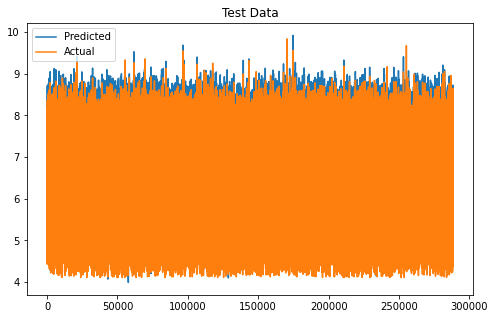

In [95]:
# visualization of actual and predicted.
plt.figure(figsize=(8,5))
plt.title('Test Data')
plt.plot(y_pred)
plt.plot(np.array(y_test))
plt.legend(["Predicted","Actual"])
plt.show()

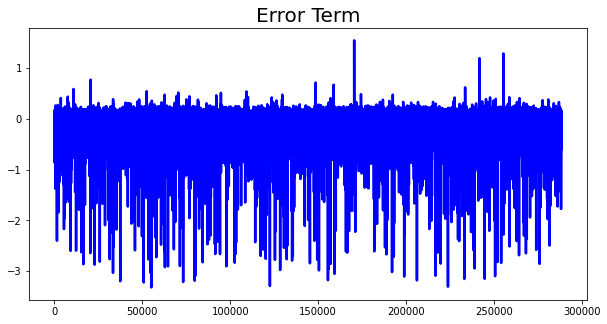

In [96]:
# visualizing the error terms
plt.figure(figsize= (10,5))
c= [i for i in range(0, len(y_test))]
plt.plot(c, y_test-y_pred, color='blue', linewidth=2.5, linestyle='-')
plt.title('Error Term', fontsize=20)
plt.show()

# Ridge Regression

In [97]:
# using pipeline to apply data preprosessing and Ridge regression together.
pipe1 = Pipeline(steps=[
                        ('step1',step1),
                        ('model',Ridge())
])

parameters = {'model__alpha': [1e-15,1e-13,1e-10,1e-8,1e-5,1e-4,1e-3,1e-2,1e-1,1,5,10,20,30,40,45,50,55,60,100]}
# using randomsearchcv for hyperparameter tunning
rsc_ridge = RandomizedSearchCV(pipe1,parameters,scoring='r2',cv=5)
#training the model
rsc_ridge.fit(X_train,y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('step1',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('log',
                                                                               FunctionTransformer(func=<ufunc 'log1p'>),
                                                                               ['speed',
                                                                                'distance']),
                                                                              ('ohe',
                                                                               OneHotEncoder(drop='first',
                                                                                             sparse=False),
                                                                               ['store_and_fwd_flag',
                                                                                'weekday_day'])])),
                                             ('model', Ridge())]),
                   param_distributions={'model__alpha': [1e-15, 1e-13, 1e-10,
                                                         1e-08, 1e-05, 0.0001,
                                                         0.001, 0.01, 0.1, 1, 5,
                                                         10, 20, 30, 40, 45, 50,
                                                         55, 60, 100]},
                   scoring='r2')

In [98]:
print('The best fit apha value is: ',rsc_ridge.best_params_)
print(f'The best r2 score by using{rsc_ridge.best_params_} is {rsc_ridge.best_score_}.')

The best fit apha value is:  {'model__alpha': 60}
The best r2 score by using{'model__alpha': 60} is 0.9589835677828349.


In [99]:
#predicting y with respect to x_test and y_test.
y_pred_ridge_test = rsc_ridge.predict(X_test)
y_pred_ridge_train = rsc_ridge.predict(X_train)

In [101]:
# using evaluation metrics to evaluate our model.
rr_train_mse = mean_squared_error(y_train,y_pred_ridge_train)
print('Train MSE',rr_train_mse)

rr_train_rmse = np.sqrt(rr_train_mse)
print('Train RMSE',rr_train_rmse)

rr_train_r2 = r2_score(y_train,y_pred_ridge_train)
print('Train R2 Score',rr_train_r2)

rr_train_adjusted_r2 = 1-(1-r2_score(y_train, y_pred_ridge_train))*((X_train.shape[0]-1)/(X_train.shape[0]-X_train.shape[1]-1))
print('Train Adjusted R2',rr_train_adjusted_r2)

Train MSE 0.02148703636629707
Train RMSE 0.14658457069656775
Train R2 Score 0.959471484820573
Train Adjusted R2 0.9594710631935075


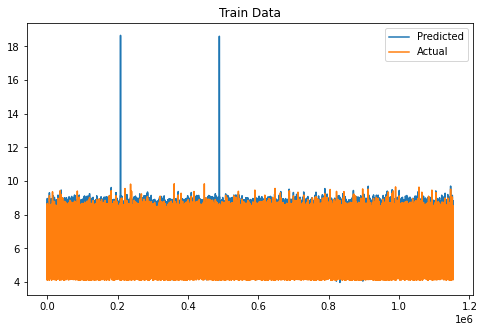

In [102]:
# visualization of actual and predicted.
plt.figure(figsize=(8,5))
plt.title('Train Data')
plt.plot(y_pred_ridge_train)
plt.plot(np.array(y_train))
plt.legend(["Predicted","Actual"])
plt.show()

In [103]:
# using evaluation metrics to evaluate our model.
rr_test_mse = mean_squared_error(y_test,y_pred_ridge_test)
print('Test MSE',rr_test_mse)

rr_test_rmse = np.sqrt(rr_test_mse)
print('Test RMSE',rr_test_rmse)

rr_test_r2 = r2_score(y_test,y_pred_ridge_test)
print('Test R2 Score',rr_test_r2)

rr_test_adjusted_r2 = 1-(1-r2_score(y_test, y_pred_ridge_test))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1))
print('Test Adjusted R2',rr_test_adjusted_r2)

Test MSE 0.021207763545873486
Test RMSE 0.14562885547127494
Test R2 Score 0.9599319775206714
Test Adjusted R2 0.9599303101213527


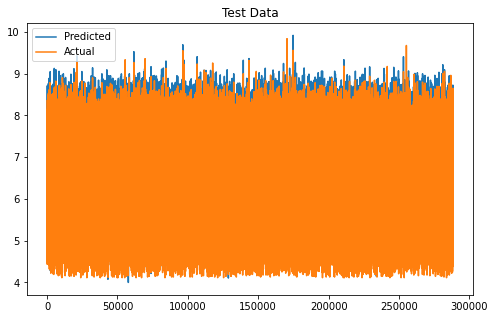

In [104]:
# visualization of actual and predicted.
plt.figure(figsize=(8,5))
plt.title('Test Data')
plt.plot(y_pred_ridge_test)
plt.plot(np.array(y_test))
plt.legend(["Predicted","Actual"])
plt.show()

# Lasso Regression

In [105]:
# using pipeline to apply data preprosessing and Lasso regression together.
pipe2 = Pipeline(steps=[
                        ('step1',step1),
                        ('model',Lasso())
])

parameters = {'model__alpha': [1e-15,1e-13,1e-10,1e-8,1e-5,1e-4,1e-3,1e-2,1e-1,1,5,10,20,30,40,45,50,55,60,100]}
rsc_lasso = RandomizedSearchCV(pipe2,parameters,scoring='r2',cv=5)
rsc_lasso.fit(X_train,y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('step1',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('log',
                                                                               FunctionTransformer(func=<ufunc 'log1p'>),
                                                                               ['speed',
                                                                                'distance']),
                                                                              ('ohe',
                                                                               OneHotEncoder(drop='first',
                                                                                             sparse=False),
                                                                               ['store_and_fwd_flag',
                                                                                'weekday_day'])])),
                                             ('model', Lasso())]),
                   param_distributions={'model__alpha': [1e-15, 1e-13, 1e-10,
                                                         1e-08, 1e-05, 0.0001,
                                                         0.001, 0.01, 0.1, 1, 5,
                                                         10, 20, 30, 40, 45, 50,
                                                         55, 60, 100]},
                   scoring='r2')

In [106]:
print('The best fit apha value is: ',rsc_lasso.best_params_)
print(f'The best r2 score by using{rsc_lasso.best_params_} is {rsc_lasso.best_score_}.')

The best fit apha value is:  {'model__alpha': 1e-05}
The best r2 score by using{'model__alpha': 1e-05} is 0.9589779380137525.


In [107]:
#predicting y with respect to x_test and y_test.
y_pred_train_lasso = rsc_lasso.predict(X_train)
y_pred_test_lasso = rsc_lasso.predict(X_test)

In [108]:
# using evaluation metrics to evaluate our model.
lasso_train_mse = mean_squared_error(y_train,y_pred_train_lasso)
print('Train MSE',lasso_train_mse)

lasso_train_rmse = np.sqrt(lasso_train_mse)
print('Train RMSE',lasso_train_rmse)

lasso_train_r2 = r2_score(y_train,y_pred_train_lasso)
print('Train R2 Score',lasso_train_r2)

lasso_train_adjusted_r2 = 1-(1-r2_score(y_train, y_pred_train_lasso))*((X_train.shape[0]-1)/(X_train.shape[0]-X_train.shape[1]-1))
print('Train Adjusted R2',lasso_train_adjusted_r2)

Train MSE 0.02148535175361829
Train RMSE 0.14657882436975092
Train R2 Score 0.9594746623109146
Train Adjusted R2 0.9594742407169052


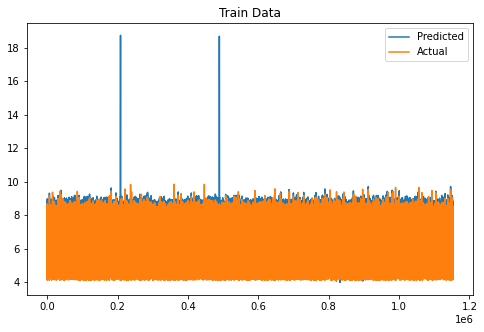

In [120]:
# visualization of actual and predicted.
plt.figure(figsize=(8,5))
plt.title('Train Data')
plt.plot(y_pred_train_lasso)
plt.plot(np.array(y_train))
plt.legend(["Predicted","Actual"])
plt.show()

In [110]:
# using evaluation metrics to evaluate our model.
lasso_test_mse = mean_squared_error(y_test,y_pred_test_lasso)
print('Test MSE',lasso_test_mse)

lasso_test_rmse = np.sqrt(lasso_test_mse)
print('Test RMSE',lasso_test_rmse)

lasso_test_r2 = r2_score(y_test,y_pred_test_lasso)
print('Test R2 Score',lasso_test_r2)

lasso_test_adjusted_r2 = 1-(1-r2_score(y_test, y_pred_test_lasso))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1))
print('Test Adjusted R2',lasso_test_adjusted_r2)

Test MSE 0.0212046626498388
Test RMSE 0.14561820851060764
Test R2 Score 0.9599378360720342
Test Adjusted R2 0.9599361689165145


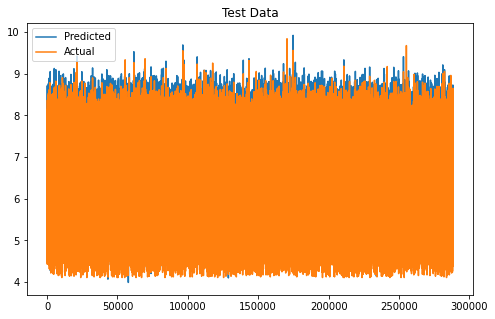

In [111]:
# visualization of actual and predicted.
plt.figure(figsize=(8,5))
plt.title('Test Data')
plt.plot(y_pred_test_lasso)
plt.plot(np.array(y_test))
plt.legend(["Predicted","Actual"])
plt.show()

#Decesion Tree

In [114]:
# using pipeline to apply data preprosessing and Decession Tree together.
pipe3 = Pipeline(steps=[
                        ('step1',step1),
                        ('model',DecisionTreeRegressor(max_depth=10))
])

pipe3.fit(X_train,y_train)

Pipeline(steps=[('step1',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('log',
                                                  FunctionTransformer(func=<ufunc 'log1p'>),
                                                  ['speed', 'distance']),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first',
                                                                sparse=False),
                                                  ['store_and_fwd_flag',
                                                   'weekday_day'])])),
                ('model', DecisionTreeRegressor(max_depth=10))])

In [118]:
#predicting y with respect to x_test and y_test.
y_pred_train_dt = pipe3.predict(X_train)
y_pred_test_dt = pipe3.predict(X_test)

In [119]:
# using evaluation metrics to evaluate our model.
MSE  = mean_squared_error(y_train, y_pred_train_dt)
print("Train MSE :" , MSE)

RMSE = np.sqrt(MSE)
print("Train RMSE :" ,RMSE)

r2 = r2_score(y_train, y_pred_train_dt)
print("Train R2 :" ,r2)
print("Train Adjusted R2 : ",1-(1-r2_score(y_train, y_pred_train_dt))*((X_train.shape[0]-1)/(X_train.shape[0]-X_train.shape[1]-1)))

Train MSE : 0.002677742254977419
Train RMSE : 0.0517469057526865
Train R2 : 0.9949492840344577
Train Adjusted R2 :  0.9949492314907477


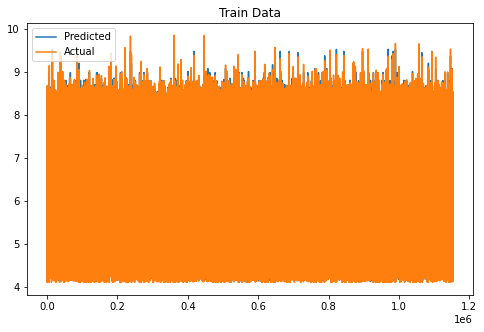

In [121]:
# visualization of actual and predicted.
plt.figure(figsize=(8,5))
plt.title('Train Data')
plt.plot(y_pred_train_dt)
plt.plot(np.array(y_train))
plt.legend(["Predicted","Actual"])
plt.show()

In [122]:
# using evaluation metrics to evaluate our model.
MSE  = mean_squared_error(y_test, y_pred_test_dt)
print("Test MSE :" , MSE)

RMSE = np.sqrt(MSE)
print("Test RMSE :" ,RMSE)

r2 = r2_score(y_test, y_pred_test_dt)
print("Test R2 :" ,r2)
print("Test Adjusted R2 : ",1-(1-r2_score((y_test), (y_pred_test_dt)))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1)))

Test MSE : 0.002735699493674182
Test RMSE : 0.052303914706971814
Test R2 : 0.9948314178167762
Test Adjusted R2 :  0.9948312027302838


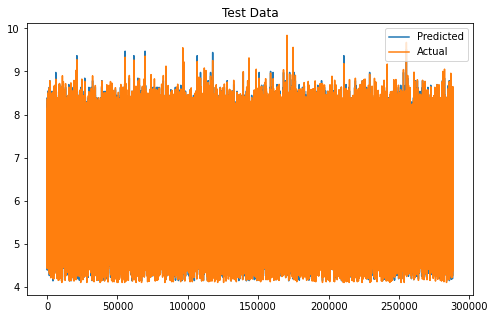

In [124]:
# visualization of actual and predicted.
plt.figure(figsize=(8,5))
plt.title('Test Data')
plt.plot(y_pred_test_dt)
plt.plot(np.array(y_test))
plt.legend(["Predicted","Actual"])
plt.show()

# XGBRegressor

In [125]:
# using pipeline to apply data preprosessing and XGBRegressor together.
pipe4 = Pipeline(steps=[
                        ('step1',step1),
                        ('model',XGBRegressor())
])

pipe4.fit(X_train,y_train)

[13:58:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Pipeline(steps=[('step1',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('log',
                                                  FunctionTransformer(func=<ufunc 'log1p'>),
                                                  ['speed', 'distance']),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first',
                                                                sparse=False),
                                                  ['store_and_fwd_flag',
                                                   'weekday_day'])])),
                ('model', XGBRegressor())])

In [126]:
#predicting y with respect to x_test and y_test.
y_pred_train_xgb = pipe4.predict(X_train)
y_test_pred_xgb = pipe4.predict(X_test)

In [127]:
# using evaluation metrics to evaluate our model.
MSE  = mean_squared_error(y_train, y_pred_train_xgb)
print("Train MSE :" , MSE)

RMSE = np.sqrt(MSE)
print("Train RMSE :" ,RMSE)

r2 = r2_score(y_train, y_pred_train_xgb)
print("Train R2 :" ,r2)
print("Train Adjusted R2 : ",1-(1-r2_score(y_train, y_pred_train_xgb))*((X_train.shape[0]-1)/(X_train.shape[0]-X_train.shape[1]-1)))

Train MSE : 0.0015590983418606208
Train RMSE : 0.03948541935779106
Train R2 : 0.9970592528566001
Train Adjusted R2 :  0.9970592222633602


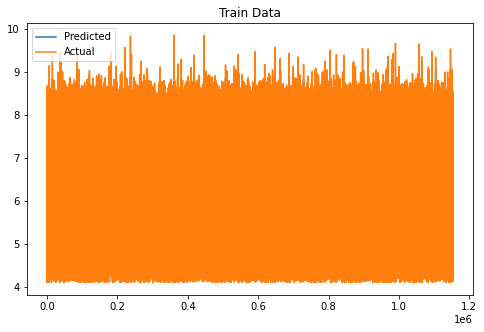

In [128]:
# visualization of actual and predicted.
plt.figure(figsize=(8,5))
plt.title('Train Data')
plt.plot(y_pred_train_xgb)
plt.plot(np.array(y_train))
plt.legend(["Predicted","Actual"])
plt.show()

In [129]:
# using evaluation metrics to evaluate our model.
MSE  = mean_squared_error(y_test, y_test_pred_xgb)
print("Test MSE :" , MSE)

RMSE = np.sqrt(MSE)
print("Test RMSE :" ,RMSE)

r2 = r2_score(y_test, y_test_pred_xgb)
print("Test R2 :" ,r2)
print("Test Adjusted R2 : ",1-(1-r2_score((y_test), (y_test_pred_xgb)))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1)))

Test MSE : 0.001580998756573382
Test RMSE : 0.03976177506819058
Test R2 : 0.9970130045263307
Test Adjusted R2 :  0.9970128802248576


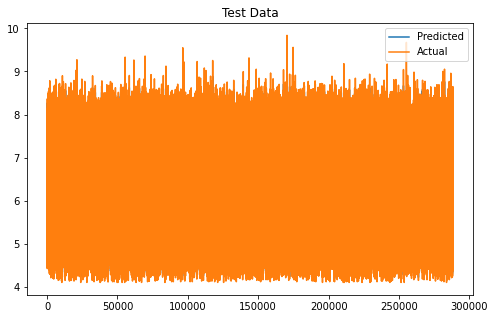

In [130]:
# visualization of actual and predicted.
plt.figure(figsize=(8,5))
plt.title('Test Data')
plt.plot(y_test_pred_xgb)
plt.plot(np.array(y_test))
plt.legend(["Predicted","Actual"])
plt.show()

# Model Summary of Training Data.

In [157]:
# creating model summary  for training data.
from prettytable import PrettyTable
train = PrettyTable(['SL NO',"MODEL_NAME", "Train MSE", "Train RMSE",'Train R^2','Train Adjusted R^2'])
train.add_row(['1','Linear Regression','0.02148703636629707','0.14658457069656775','0.959471484820573','0.9594710631935075'])
train.add_row(['2','Lasso Regression','0.02148535175361829','0.14657882436975092','0.9594746623109146','0.9594742407169052'])
train.add_row(['3','Ridge Regression ','0.02148703636629707','0.14658457069656775','0.959471484820573','0.9594710631935075'])
train.add_row(['4','DecisionTree Regressor','0.002677742254977419','0.0517469057526865','0.9949492840344577','0.9949492314907477'])
train.add_row(['5','XGBRegressor','0.0015590983418606208','0.03948541935779106','0.9970592528566001','0.9970592222633602'])
print(train)

+-------+------------------------+-----------------------+---------------------+--------------------+--------------------+
| SL NO |       MODEL_NAME       |       Train MSE       |      Train RMSE     |     Train R^2      | Train Adjusted R^2 |
+-------+------------------------+-----------------------+---------------------+--------------------+--------------------+
|   1   |   Linear Regression    |  0.02148703636629707  | 0.14658457069656775 | 0.959471484820573  | 0.9594710631935075 |
|   2   |    Lasso Regression    |  0.02148535175361829  | 0.14657882436975092 | 0.9594746623109146 | 0.9594742407169052 |
|   3   |   Ridge Regression     |  0.02148703636629707  | 0.14658457069656775 | 0.959471484820573  | 0.9594710631935075 |
|   4   | DecisionTree Regressor |  0.002677742254977419 |  0.0517469057526865 | 0.9949492840344577 | 0.9949492314907477 |
|   5   |      XGBRegressor      | 0.0015590983418606208 | 0.03948541935779106 | 0.9970592528566001 | 0.9970592222633602 |
+-------+-------

#Model Summary of Test Data.

In [158]:
# creating model summary  for test data.
from prettytable import PrettyTable
test = PrettyTable(['SL NO',"MODEL_NAME", "Test MSE", "Test RMSE",'Test R^2','Test Adjusted R^2'])
test.add_row(['1','Linear Regression','0.021207763545873486','0.14562885547127494','0.9599319775206714','0.9599303101213527'])
test.add_row(['2','Lasso Regression','0.0212046626498388','0.14561820851060764','0.9599378360720342','0.9599361689165145'])
test.add_row(['3','Ridge Regression ','0.021207763545873486','0.14562885547127494','0.9599319775206714','0.9599303101213527'])
test.add_row(['4','DecisionTree Regressor','0.002735699493674182','0.052303914706971814','0.9948314178167762',' 0.9948312027302838'])
test.add_row(['5','XGBRegressor','0.001580998756573382','0.03976177506819058','0.9970130045263307','0.9970128802248576'])
print(test)

+-------+------------------------+----------------------+----------------------+--------------------+---------------------+
| SL NO |       MODEL_NAME       |       Test MSE       |      Test RMSE       |      Test R^2      |  Test Adjusted R^2  |
+-------+------------------------+----------------------+----------------------+--------------------+---------------------+
|   1   |   Linear Regression    | 0.021207763545873486 | 0.14562885547127494  | 0.9599319775206714 |  0.9599303101213527 |
|   2   |    Lasso Regression    |  0.0212046626498388  | 0.14561820851060764  | 0.9599378360720342 |  0.9599361689165145 |
|   3   |   Ridge Regression     | 0.021207763545873486 | 0.14562885547127494  | 0.9599319775206714 |  0.9599303101213527 |
|   4   | DecisionTree Regressor | 0.002735699493674182 | 0.052303914706971814 | 0.9948314178167762 |  0.9948312027302838 |
|   5   |      XGBRegressor      | 0.001580998756573382 | 0.03976177506819058  | 0.9970130045263307 |  0.9970128802248576 |
+-------

# By the above Tables we can conclude that XGBRegressor pereforming very well with R2 Score of 0.9970 ,followed by DecisionTree Regressor with R2 Score of 0.9948.